# Controversy in Reddit Posts

### Let's load useful libraries first

In [1]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.util import ngrams
import re

/Users/hoosier/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


### And the most popular categories are

In [2]:
sql_conn = sql.connect('./database.sqlite')
df0 = pd.read_sql("SELECT subreddit, Count(*) as count FROM May2015 GROUP BY subreddit ORDER BY Count(subreddit) DESC", sql_conn)

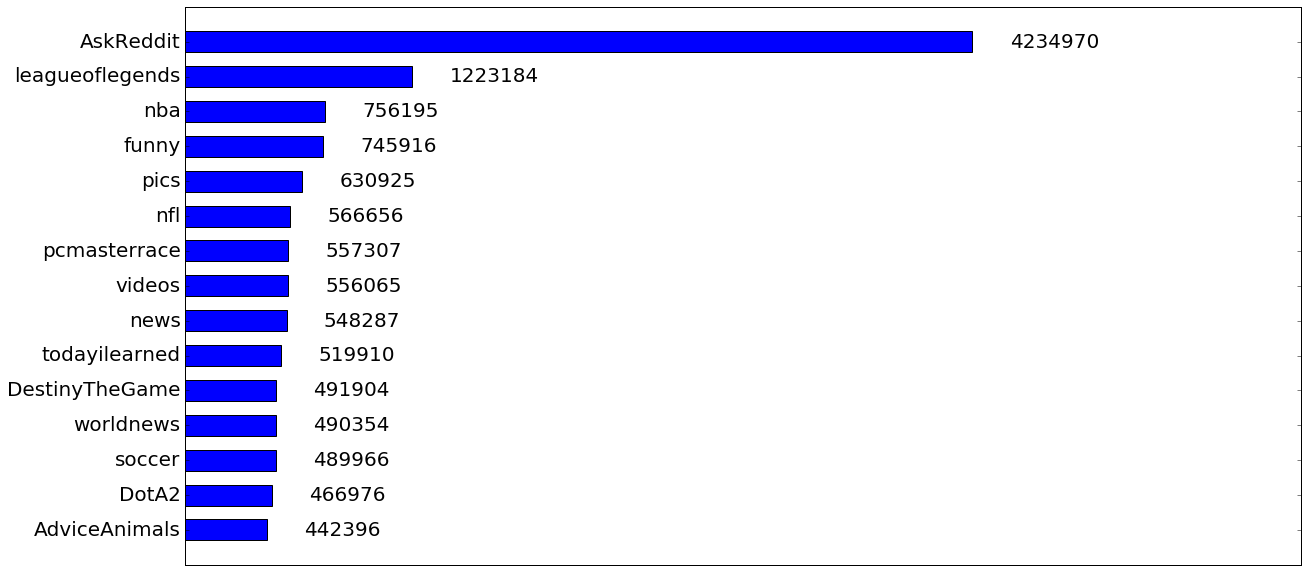

In [3]:
top15=df0.iloc[:15]
plt.figure(figsize=(20,10))
y_pos = np.arange(1,len(top15)+1)
top15=top15.sort_index(ascending=False)
width_=0.6
plt.barh(y_pos-width_/2, top15["count"],width_)
plt.xticks([])
plt.yticks(y_pos, top15["subreddit"],fontsize=20)
for a,b in zip(top15["count"], y_pos):
    plt.text(a+200000, b, str(a),fontsize=20,verticalalignment='center')
plt.xlim([0,6e6])    
plt.show()


Numbers on the right side of the figure above show the total number of comments for the corresponding subreddits

### Load 5 million random comments

5 million random comments were previously pulled from the database and stored in a pickle file. See GetRandomLines.py for details.

In [4]:
df_5mil=pd.read_pickle("Data5000000.p") 
ind=[x !='moderator' for x in df_5mil['distinguished']]
df_5mil=df_5mil.loc[ind] #remove moderator comments
ind=[len(x)>200 for x in df_5mil['body']]
df_5mil=df_5mil.loc[ind] #keep only long comments 

In [5]:
len(df_5mil) # down to 1133331 comments

1133331

In [6]:
sum(df_5mil['controversiality']) # Number of controversial comments is 33685

33685

### And the most controversial categories are

In [7]:
piv_table = pd.pivot_table(df_5mil[['subreddit','controversiality']], index=['subreddit'], values=['controversiality'], aggfunc=[np.mean, len])
ind=piv_table[('len','controversiality')]>100 #use only if they have more than 100 comments
piv_table = piv_table.loc[ind] 

In [8]:
top15 = piv_table[("mean","controversiality")].sort_values(ascending=False).iloc[:15]

In [9]:
top15=top15.sort_values(ascending=True)*100

In [10]:
lv=list()
lf=list()
for v in top15.index:
    lv.append(df0.loc[df0['subreddit']==v].index[0]+1)
    lf.append(df0['count'].loc[df0['subreddit']==v].iloc[0])

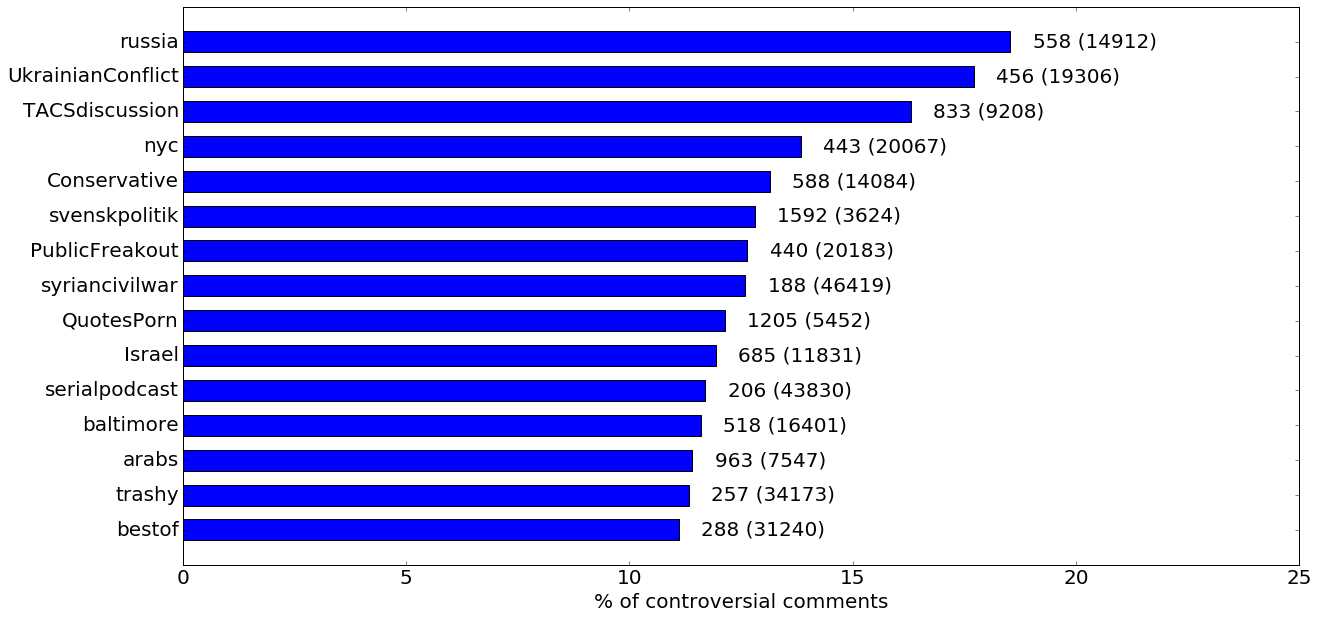

In [11]:
plt.figure(figsize=(20,10))
y_pos = np.arange(1,len(top15)+1)
width_=0.6
plt.barh(y_pos-width_/2, top15,width_)
plt.xticks(fontsize=20)
plt.yticks(y_pos, top15.index,fontsize=20)
#plt.rc('xtick', labelsize=20) 
#plt.rc('ytick', labelsize=20)
plt.xlabel('% of controversial comments',fontsize=20)
for a,b,c,d in zip(top15, y_pos, lv, lf):
    val=str(c) + ' (' + str(d) + ')'
    plt.text(a+0.5, b, val,fontsize=20,verticalalignment='center')
plt.xlim([0,25])    
plt.show()



Numbers on the right side of the figure above are in format "rank (number of comments)" where rank represent rank of the subreddits based on the total number of comments 

### Let's check popularity vs. controversiality 

In [12]:
x=piv_table[("mean","controversiality")]*100

In [13]:
len(x)

1418

In [14]:
y=list()
for v in x.index:
    y.append(df0['count'].loc[df0['subreddit']==v].iloc[0])

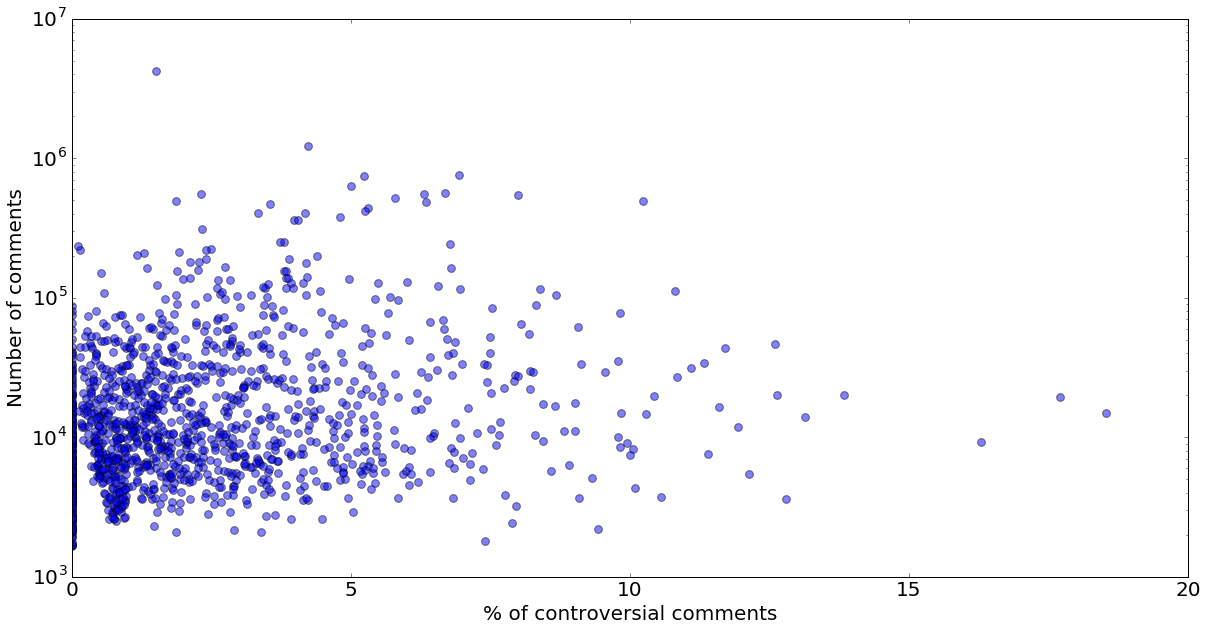

In [15]:
plt.figure(figsize=(20,10))
plt.scatter(x,y,s=60,alpha=0.5)
plt.xlabel('% of controversial comments',fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Number of comments',fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([-0.,20])
plt.yscale('log')
plt.show()

### Is the score distribution different for controversial and non-controversial posts?

In [16]:
ind=df_5mil["controversiality"]>0
df_5mil_contr=df_5mil.loc[ind]
df_5mil_noncontr=df_5mil.loc[np.invert(ind)]
del df_5mil

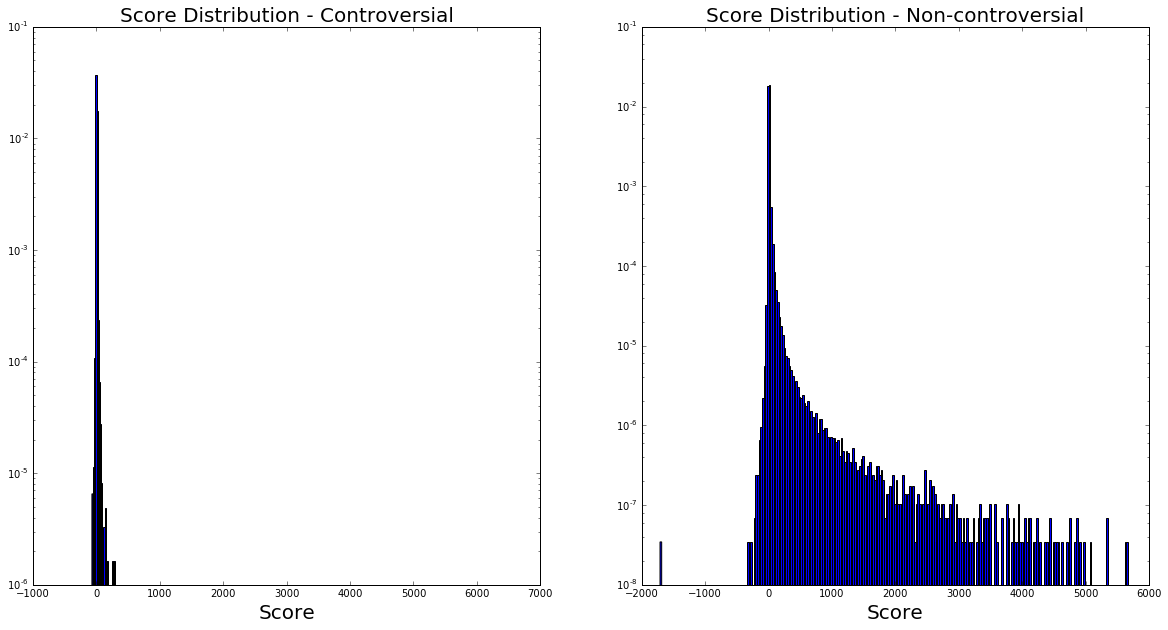

In [17]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.hist(df_5mil_contr["score"],bins=20,normed=True)
plt.yscale('log')
plt.xlabel("Score",fontsize=20)
plt.xlim([-1000,7000])
plt.title("Score Distribution - Controversial",fontsize=20)
plt.subplot(1,2,2)
plt.hist(df_5mil_noncontr["score"],bins=280,normed=True)
plt.yscale('log')
plt.title("Score Distribution - Non-controversial",fontsize=20)
plt.xlabel("Score",fontsize=20)
plt.show()

In [18]:
del df0

### Let's look at the most popular phrases (4-grams and 5-grams) in the comments

Convert comments to lower case, remove special symbols, punctuation, and combine together in one text:

In [19]:
a=[text.lower() for text in df_5mil_contr['body']]
b=' '.join(a)
b1=re.sub('\[a-z]',' ',b)
s = re.sub(r'[^\w\s]',' ',b1)
final_text=re.sub('[\t\n\r\f\v]','',s)
del a,b,b1,s, df_5mil_contr

In [20]:
tokens=nltk.word_tokenize(final_text)
del final_text

In [21]:
fivegrams = ngrams(tokens, 5)

In [22]:
fdist_5 = nltk.FreqDist(fivegrams)

In [23]:
contr5=fdist_5.most_common(20)

In [24]:
fourgrams = ngrams(tokens, 4)
fdist_4 = nltk.FreqDist(fourgrams)
contr4=fdist_4.most_common(20)

In [25]:
del fivegrams,fourgrams,fdist_5,fdist_4,tokens

In [26]:
x=[' '.join(ind[0]) for ind in contr4]

In [27]:
y=[ind[1] for ind in contr4]

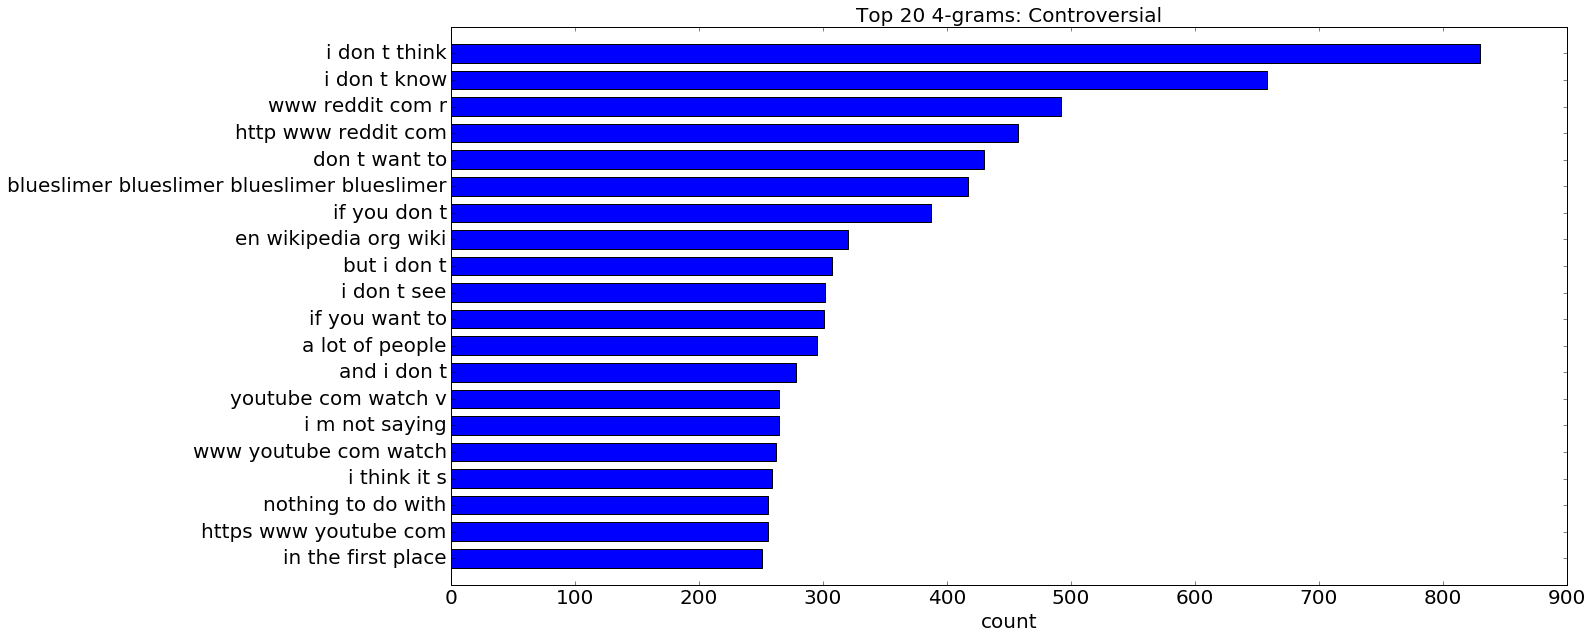

In [28]:
top=y[:20]
x=x[:20]
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
y_pos = np.arange(len(top),0,-1)
width_=0.7
ax.barh(y_pos-width_/2, top,width_)
ax.set_yticklabels(x,fontsize=20)
ax.set_yticks(y_pos)
plt.ylim([0,max(y_pos)+1])
plt.title('Top 20 4-grams: Controversial',fontsize=20)
plt.xlabel('count',fontsize=20)
plt.xticks(fontsize=20)
plt.show()

In [29]:
x=[' '.join(ind[0]) for ind in contr5]
y=[ind[1] for ind in contr5]

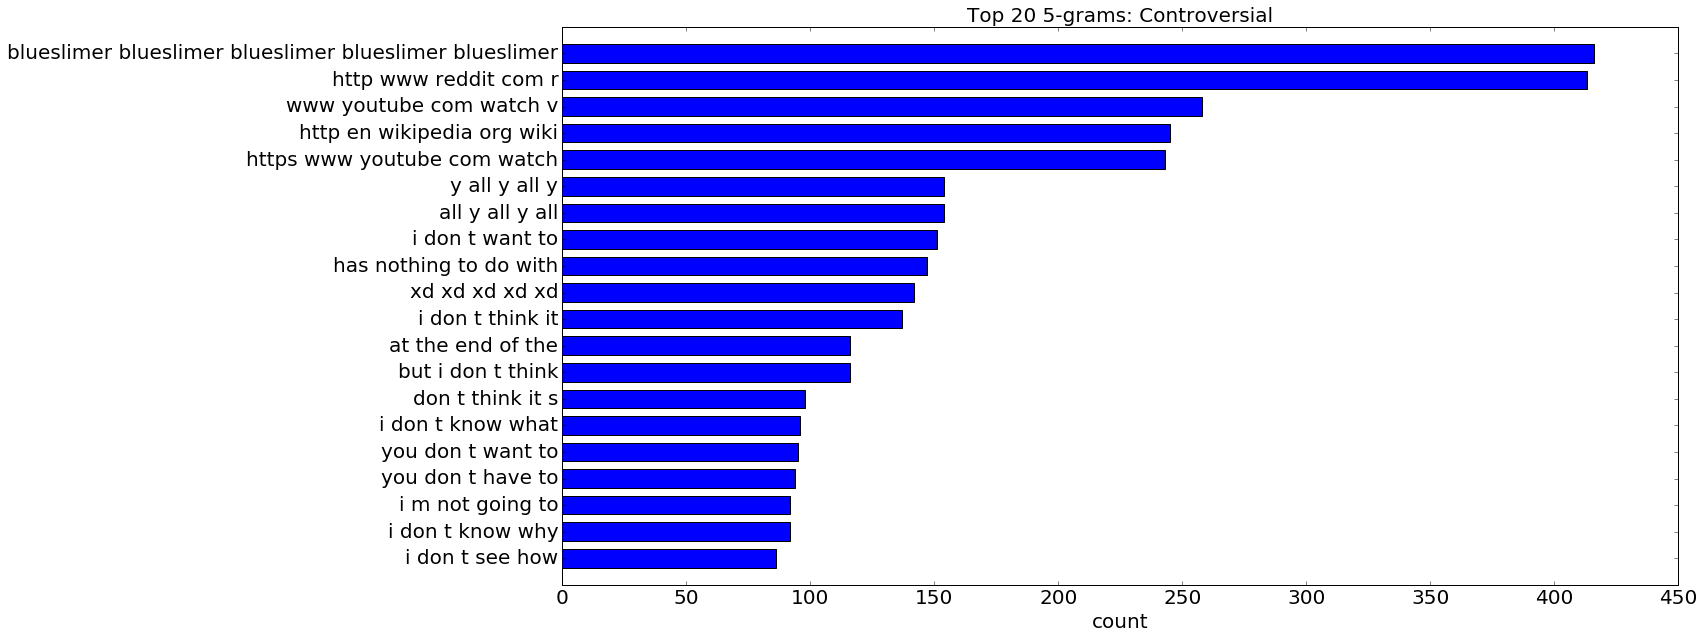

In [30]:
top=y[:20]
x=x[:20]
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
y_pos = np.arange(len(top),0,-1)
width_=0.7
ax.barh(y_pos-width_/2, top,width_)
ax.set_yticklabels(x,fontsize=20)
ax.set_yticks(y_pos)
plt.ylim([0,max(y_pos)+1])
plt.title('Top 20 5-grams: Controversial',fontsize=20)
plt.xlabel('count',fontsize=20)
plt.xticks(fontsize=20)
plt.show()

In [31]:
df=df_5mil_noncontr.sample(n=500000,random_state=2000) #need to reduce the size to process in reasonable amount of time 

In [32]:
del df_5mil_noncontr

In [33]:
a=[text.lower() for text in df['body']]
b=' '.join(a)
b1=re.sub('\[a-z]',' ',b)
s = re.sub(r'[^\w\s]',' ',b1)
final_text_non=re.sub('[\t\n\r\f\v]','',s)
del a,b,b1,s, df

In [34]:
tokens_non=nltk.word_tokenize(final_text_non)
del final_text_non

In [35]:
fivegrams_non = ngrams(tokens_non, 5)

In [36]:
fdist_5_non = nltk.FreqDist(fivegrams_non)

In [37]:
noncontr5=fdist_5_non.most_common(100)
del fivegrams_non, fdist_5_non

In [38]:
fourgrams_non = ngrams(tokens_non, 4)
fdist_4_non = nltk.FreqDist(fourgrams_non)
noncontr4=fdist_4_non.most_common(100)
del fourgrams_non, fdist_4_non, tokens_non

In [44]:
x=[' '.join(ind[0]) for ind in noncontr4]
y=[ind[1] for ind in noncontr4]

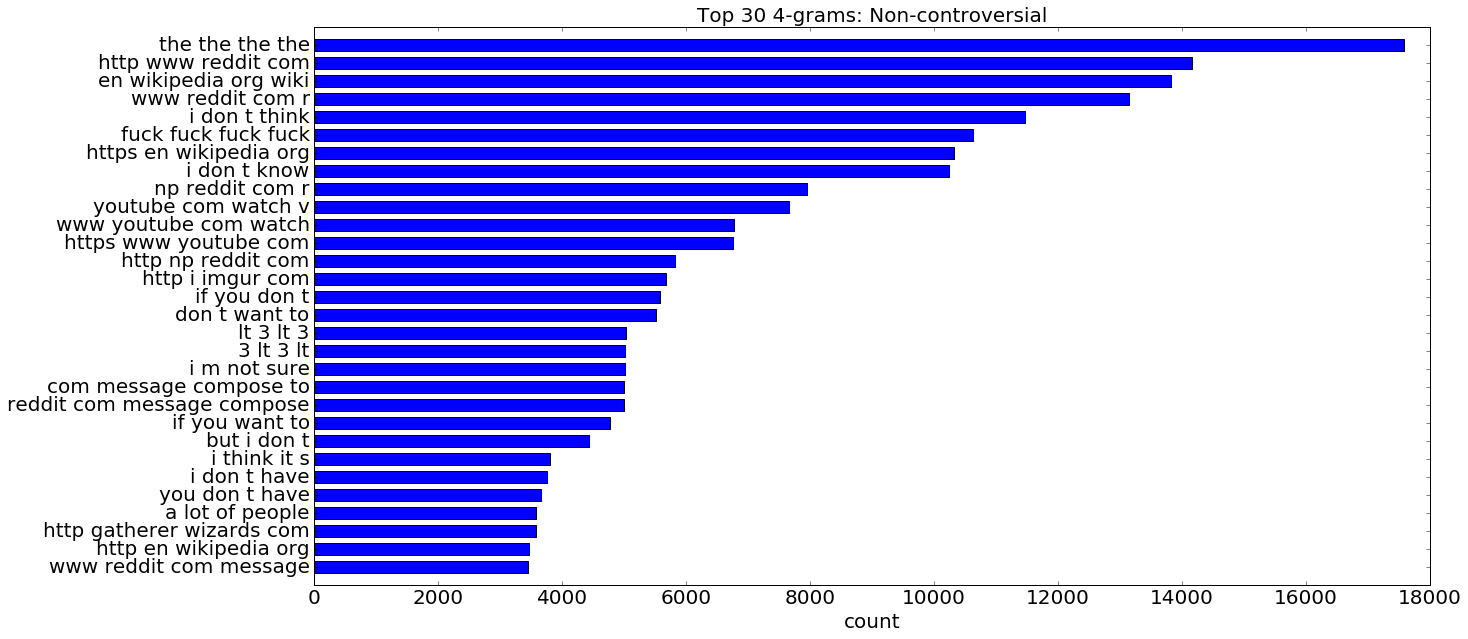

In [46]:
top=y[:30]
x=x[:30]
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
y_pos = np.arange(len(top),0,-1)
width_=0.7
ax.barh(y_pos-width_/2, top,width_)
ax.set_yticklabels(x,fontsize=20)
ax.set_yticks(y_pos)
plt.ylim([0,max(y_pos)+1])
plt.title('Top 30 4-grams: Non-controversial',fontsize=20)
plt.xlabel('count',fontsize=20)
plt.xticks(fontsize=20)
plt.show()

In [47]:
x=[' '.join(ind[0]) for ind in noncontr5]
y=[ind[1] for ind in noncontr5]

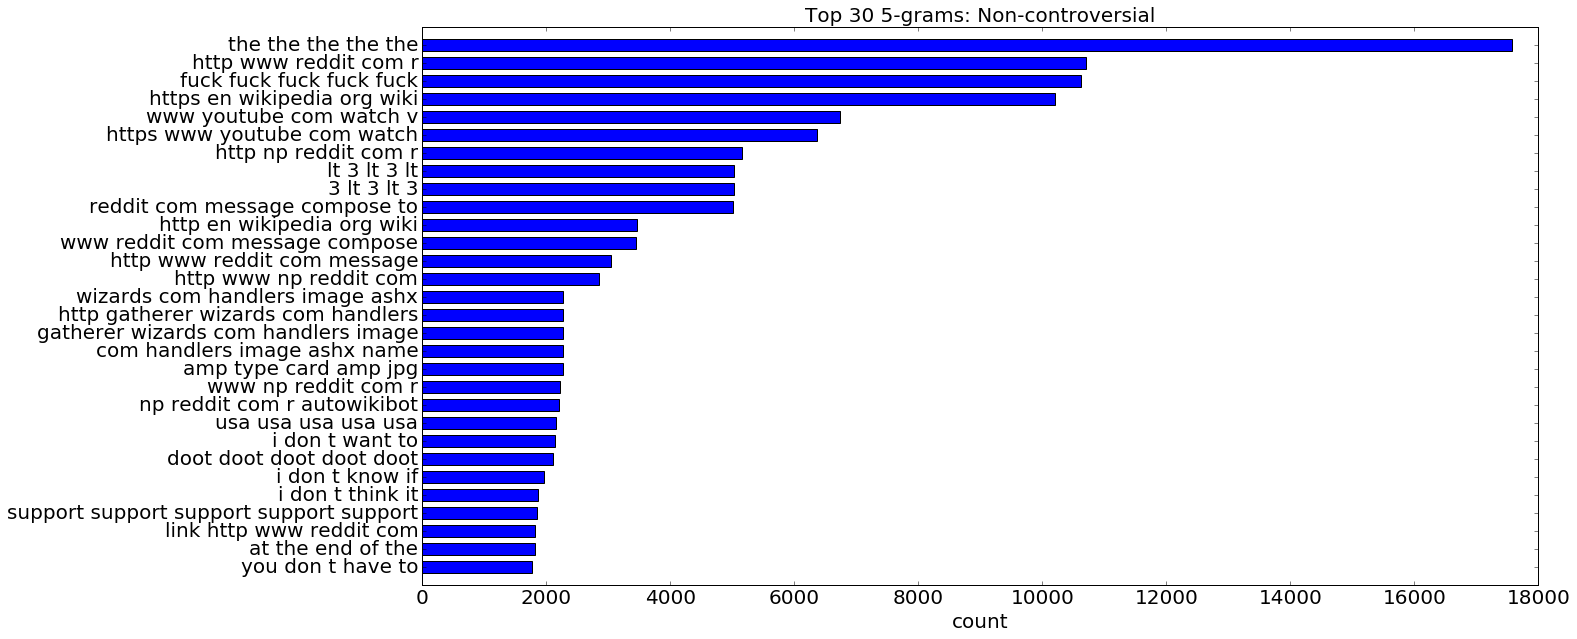

In [48]:
top=y[:30]
x=x[:30]
fig=plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
y_pos = np.arange(len(top),0,-1)
width_=0.7
ax.barh(y_pos-width_/2, top,width_)
ax.set_yticklabels(x,fontsize=20)
ax.set_yticks(y_pos)
plt.ylim([0,max(y_pos)+1])
plt.title('Top 30 5-grams: Non-controversial',fontsize=20)
plt.xlabel('count',fontsize=20)
plt.xticks(fontsize=20)
plt.show()